# Modèle CNN

## Imports

In [32]:
import os
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

## Connexion à la BDD

In [33]:
db_path = os.path.abspath("../db.sqlite3")
print("Connexion à :", db_path)

conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables présentes :", cursor.fetchall())

Connexion à : /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Solution Delivery/SolutionDelivery_PRJ/backend/src/db.sqlite3
Tables présentes : [('Image',), ('Location',), ('sqlite_sequence',), ('AppConfig',), ('ClassificationConstraints',)]


## Chargement des données train

In [34]:
query_train = "SELECT Id_Image, File_path, Status FROM Image WHERE Id_Image > 100"
df_train = pd.read_sql_query(query_train, conn)
print(f"Nombre d'images train : {len(df_train)}")

Nombre d'images train : 600


## Chargement des données test

In [35]:
query_test = "SELECT Id_Image, File_path, Status FROM Image WHERE Id_Image <= 100"
df_test = pd.read_sql_query(query_test, conn)
print(f"Nombre d'images test : {len(df_test)}")

Nombre d'images test : 100


## Fonction de préprocessing image

In [36]:
def load_and_preprocess(img_path, target_size=(128,128)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

## Préparation X, y (train)

In [37]:
images_train, labels_train = [], []
for _, row in df_train.iterrows():
    id_image = row['Id_Image']
    img_path = os.path.abspath(f"../../src/media/Data/crops/crop_{id_image}.webp")
    if os.path.exists(img_path):
        images_train.append(load_and_preprocess(img_path))
        labels_train.append(row['Status'])
    else:
        print(f"⚠️ Image manquante : {img_path}")

X = np.array(images_train)
y = np.array(labels_train)

print("✅ Train loaded :", X.shape, y.shape)

✅ Train loaded : (600, 128, 128, 3) (600,)


## Cross-Validation

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_acc, cv_loss = [], []

print("\n🔎 Cross-Validation (5 folds)")
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\nFold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = Sequential([
        Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
        MaxPooling2D(2,2),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=0)

    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f"Loss: {scores[0]:.4f} | Accuracy: {scores[1]*100:.2f}%")
    cv_acc.append(scores[1])
    cv_loss.append(scores[0])

print("\n📊 Cross-validation summary :")
print(f"Mean accuracy: {np.mean(cv_acc)*100:.2f}% (+/- {np.std(cv_acc)*100:.2f}%)")
print(f"Mean loss: {np.mean(cv_loss):.4f} (+/- {np.std(cv_loss):.4f})")


🔎 Cross-Validation (5 folds)

Fold 1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss: 0.5020 | Accuracy: 74.17%

Fold 2
Loss: 0.4271 | Accuracy: 83.33%

Fold 3
Loss: 0.5256 | Accuracy: 78.33%

Fold 4
Loss: 0.5098 | Accuracy: 72.50%

Fold 5
Loss: 0.5497 | Accuracy: 77.50%

📊 Cross-validation summary :
Mean accuracy: 77.17% (+/- 3.75%)
Mean loss: 0.5028 (+/- 0.0412)


## Entraînement final

In [39]:
print("\n🏁 Training final model on full train set with validation split")

final_model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_final = final_model.fit(X, y, epochs=10, validation_split=0.2)


🏁 Training final model on full train set with validation split
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5413 - loss: 0.7684 - val_accuracy: 0.4917 - val_loss: 0.6448
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6523 - loss: 0.6239 - val_accuracy: 0.7917 - val_loss: 0.5585
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7638 - loss: 0.5211 - val_accuracy: 0.8083 - val_loss: 0.4251
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8013 - loss: 0.4452 - val_accuracy: 0.7750 - val_loss: 0.4523
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8268 - loss: 0.4072 - val_accuracy: 0.8167 - val_loss: 0.4024
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8818 - loss: 0.3067 - val_accuracy: 0.7917 - val_loss: 0.4237
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9264 - loss: 0.2528 - val_accuracy: 0.8167 - val_loss: 0.4061
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/s

## Sauvegarder le modèle entraîné

In [40]:
final_model.save("trashmap_cn_crop.keras")
print("✅ Modèle final sauvegardé")

✅ Modèle final sauvegardé


## Évaluation sur train

In [41]:
y_pred_train = (final_model.predict(X) > 0.5).astype("int32")
print("\n📈 Evaluation sur train :")
print(classification_report(y, y_pred_train))
print(confusion_matrix(y, y_pred_train))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

📈 Evaluation sur train :
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       316
           1       0.98      0.88      0.93       284

    accuracy                           0.93       600
   macro avg       0.94      0.93      0.93       600
weighted avg       0.94      0.93      0.93       600

[[310   6]
 [ 34 250]]


## Courbes du modèle final

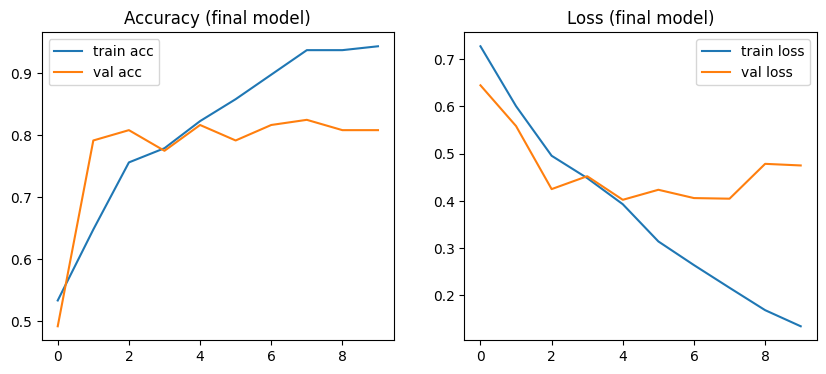

In [42]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_final.history['accuracy'], label='train acc')
plt.plot(history_final.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy (final model)")

plt.subplot(1,2,2)
plt.plot(history_final.history['loss'], label='train loss')
plt.plot(history_final.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss (final model)")
plt.show()

## Évaluation sur test

In [43]:
images_test, labels_test = [], []
for _, row in df_test.iterrows():
    id_image = row['Id_Image']
    img_path = os.path.abspath(f"../../src/media/Data/crops/crop_{id_image}.webp")
    if os.path.exists(img_path):
        images_test.append(load_and_preprocess(img_path))
        labels_test.append(row['Status'])
    else:
        print(f"⚠️ Image manquante : {img_path}")

X_test = np.array(images_test)
y_test = np.array(labels_test)

print("✅ Test set loaded :", X_test.shape)

y_pred_test = (final_model.predict(X_test) > 0.5).astype("int32")
print("\n📈 Evaluation sur test :")
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

✅ Test set loaded : (100, 128, 128, 3)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

📈 Evaluation sur test :
              precision    recall  f1-score   support

           0       0.72      0.96      0.82        51
           1       0.94      0.61      0.74        49

    accuracy                           0.79       100
   macro avg       0.83      0.79      0.78       100
weighted avg       0.83      0.79      0.78       100

[[49  2]
 [19 30]]
